In [1]:
#!pip install yfinance

# Stock Portfolio Optimization - Monte Carlo Simulation
## Problem Statement
Select a stock portfolio that optimizes the return of the portfolio for a given timeframe at a given risk level. 

The basic Portfolio Optimization problem is to decide how much of an investor’s wealth should be invested in each of the assets of a portfolio in order to reach the Objective of maximizing Sharpe Ratio.


# Data Sources

### yfinance
yfinance uses Yahoo's publicaly available API for making market data available. In this notebook, we are using yfinance python library for accessing historical stock price data.


### FRED Economic Data | St. Louis FED

#### US Inflation Rate

https://fred.stlouisfed.org/series/T10YIEM

10-Year Breakeven Inflation Rate (T10YIEM)

Units: Percent, Not Seasonally Adjusted

Frequency: Monthly

Suggested Citation:
Federal Reserve Bank of St. Louis, 10-Year Breakeven Inflation Rate [T10YIEM], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/T10YIEM, February 7, 2023.

#### US Consumer Price Index (CPI) Data

https://fred.stlouisfed.org/series/MEDCPIM158SFRBCLE

Median Consumer Price Index (MEDCPIM158SFRBCLE)

Source: Federal Reserve Bank of Cleveland  

Units:  Percent Change at Annual Rate, Seasonally Adjusted

Frequency:  Monthly

Suggested Citation:
Federal Reserve Bank of Cleveland, Median Consumer Price Index [MEDCPIM158SFRBCLE], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MEDCPIM158SFRBCLE, February 8, 2023.


## Import Libraries

In [2]:
# import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from dateutil import rrule
from dateutil import relativedelta
import locale

#import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import seaborn as sns
import sqlite3

from scipy import stats
from scipy.stats.mstats import gmean

# Pandas display settings
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_firmat = 'retina'


## Time Window and Other Constants
Our initial target is to use past ten years of stock price data. Later we will revise this window depending on availability of stock price data.

After reviewing yfinance data, we decided to set START_DATE to the beginning of year 2015 (actually it is the last day of the prior year 2014). It provides us with eight complete years stock price data, plus first few months of 2023.


In [3]:
# Start and end dates are assigned for capturing ten years of stock price history.
END_DATE = dt.datetime.now()
#START_DATE = '2014-12-31'

OPTIMIZATION_RULE = 'MSR' # Optimization Rules: MSR - Max Sharpe Ratio, MVL - Min Volatility, HBR - Hybrid

NUM_SIMULATIONS = 100_000 # 1_000_000 # Number of times Monte Carlo Simulation to be run for each of the portfolios

DEBUG = False # whether debug mode; in debug mode file names contain CODE_VERSION suffix

CODE_VERSION = 'v0.1.3' # S/W version to identify the code being run

NUM_TRADING_DAYS = 252 # Number of trading days in a year

TRAIN_FREQ = 'M' # Training frequency - M-Monthly, Q-Quarterly, A-Annually

REAL_RETURNS = False # whether real returns are factored in

RISK_FREE_RATE = 0.0397 # Risk free rate is 3.97%

SHARPE_RATIO_THRESHOLD = 1.0 # Sharpe Ratio Thresholds

VOLATILITY_THRESHOLD = 0.30 # Volatility threshold

SP500_10YEAR_AVG = 0.1274 # S&P 10 Year Average (with dividend reinvestment) is 12.74%

# All Template Portfolios
ALL_PORTFOLIOS = {
    # Starter Stock Portfolio
    'STARTER': ['AAPL', 'BRK-B', 'COST', 'GOOGL', 'KO', 'MSFT', 'NEE', 'PFE', 'T'],
    # Large Cap Blue-Chips Portfolio
    'LARGE CAP': ['AAPL', 'BRK-B','COST', 'GOOGL', 'KO', 'MSFT', 'MCD', 'VZ'],
    # Dividend Stocks Portfolio
    'DIVIDEND': ['CAT', 'CVX', 'JNJ', 'LOW', 'MCD', 'PEP', 'PG', 'TGT', 'WBA', 'WMT'],
    # Value Stock Poprtfolio
    'VALUE': ['AAPL', 'BAC', 'KO', 'CVX', 'AXP', 'OXY', 'MCO', 'USB', 'ATVI', 'HPE'],
    # Growth Stock Portfolio
    'GROWTH': ['AAPL', 'AMZN', 'GOOGL', 'META', 'NFLX'],
    # Beat the market portfolio
    'BEAT THE MARKET': ['AMD', 'DXCM', 'ECL', 'FICO', 'MA', 'MSFT', 'NFLX', 'NVO', 'PAYC', 'PCTY', 'PYPL', 'SEDG'],
    # My own stock portfolio
    'MY PORTFOLIO': ['AAPL', 'AMZN', 'GOOGL', 'GS', 'JNJ', 'MSFT', 'PFE'],
    # SPY only
    'SPY ONLY': ['SPY']
}

# All ticker symbols associated with all Template Portfolios
ALL_SYMBOLS = [] 
for portfolio_name, portfolio_symbols in ALL_PORTFOLIOS.items():
    for symbol in portfolio_symbols:
        if not(symbol in ALL_SYMBOLS):
            ALL_SYMBOLS.append(symbol)

# Seed is set to a fixed value for reproducability of results between runs
SEED = 11
np.random.seed(SEED)

# Database name where prepared data is saved for later use
DB_NAME = 'mc_sim.db'
ALL_DAILY_RETURNS_TABLE = 'all_daily_returns'


## Common Routines

In [4]:
def get_optm_rule_name(rule):
    """
    Gets optimization rule name for the rule
    Input:
    - rule - code representing optimization rule
    Output:
    - name - descriptive name of the optimization rule
    """
    # Dictionary for optimization rule name
    p_name = {
        'MSR': 'Maximize Sharpe Ratio',
        'MVL': 'Minimize Volatility',
        'HBR': 'Hybrid Optimization'
    }
    
    # Return optimization rule name 
    return p_name.get(rule, rule + ' not supported')
    

In [5]:
def get_period_attr(period):
    """
    Gets period attributes, (a) name and (b) window
    Input:
    - period - code representing period type
    Output:
    - name - name of the period
    - window - length of the period in number of months
    """
    # Dictionary for period name
    p_name = {
        'M': 'Monthly',
        'Q': 'Quarterly',
        'A': 'Annually'
    }
    
    # Dictionary for period window
    p_window = {
        'M': 1,
        'Q': 3,
        'A': 12
    }
    
    # Get period attributes using dictionaries
    name = p_name.get(period, period + ' not supported')
    window = p_window.get(period, period + ' not supported')
    
    # Return period attributes
    return name, window


In [6]:
def display_hyper_parameters(start_year, end_year, model_file):
    """
    Print hyper parameter values
    Input:
    - None
    Output:
    - Print hyper parameter values
    """
    freq_name, _ = get_period_attr(TRAIN_FREQ)
    
    print(f'\nMONTE CARLO SIMULATION TRAINING RESULTS')
    print(f'=======================================')
    print('\nHyper Parameters:')
    print(f'Run Date/time ........................ {dt.datetime.now()}')
    print(f'Training Start Year .................. {start_year}') 
    print(f'Training End Year .................... {end_year}')     
    print(f'Training Frequency ................... {freq_name}')
    print(f'Risk Free Return ..................... {RISK_FREE_RATE}')
    print(f'S&P 10 Year Averge Return ............ {SP500_10YEAR_AVG}')
    print(f'Trading Days / Year .................. {NUM_TRADING_DAYS}')
    print(f'Optimization Rule .................... {get_optm_rule_name(OPTIMIZATION_RULE)}')
    print(f'Calculate Real Returns ............... {REAL_RETURNS}')
    print(f'Sharpe Ratio Thresholds .............. {SHARPE_RATIO_THRESHOLD}')
    print(f'Volatility Thresholds ................ {VOLATILITY_THRESHOLD}')
    print(f'Number of Simulations / Portfolio .... {NUM_SIMULATIONS}')
    print(f'Random Seed .......................... {SEED}')
    print(f'Software/Code Version ................ {CODE_VERSION}')
    print(f'Debug Mode ........................... {DEBUG}')
    print(f'Model File ........................... {model_file}')
    print(' ')


In [7]:
def plot_data(df, title_text, x_label, y_label, colors=['r', 'g', 'b', 'm', 'c']):
    """
    Plot line graph for the dataframe
    Input:
    - df - dataframe to be plotted
    - title - title of the plot
    Output:
    - the plot
    """
    # Set clors array
    #colors = ['r', 'g', 'b', 'm', 'c'] 
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8), dpi=150)

    # For each ticker plot data
    i = 0
    for column in df.columns:
        df[column].plot(label=column, color=colors[i])
        i += 1
    
    # Adding titles and X label to the subplot
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title_text)

    # Display legend and show
    ax.legend()
    plt.show();
    

In [8]:
def get_period_window(freq):
    """
    For a given freqency returns window and period
    Input:
    - freq - frequency of training (M-Monthly, Q-Quarterly, A-Annualy, W-Weekly)
    Output:
    - period - period for the unit of the window
    - window - length of the training data in period units
    """        
    if freq == 'M':
        period = 'months'
        window = 1
    elif freq == 'Q':
        period = 'months'
        window = 3
    elif freq == 'A':
        period = 'months'
        window = 12
    elif freq == 'W':
        period = 'days'
        window = 7

    return period, window


In [9]:
def g_mean(x):
    """
    Returns geometric mean of returns
    Input:
    - x - returns data 
    Output:
    - Returns annualized geometric mean of returns
    """
    return gmean(1.0 + x) - 1.0


In [10]:
def get_moving_average(df, window):
    """
    Finds moving average of the stock prices 
    Input:
    - df - dataframe containing stock prices
    - window - rolling window size
    Output:
    - Mean prices
    """
    return df.rolling(window).mean()


In [11]:
def get_daily_returns(db_name):
    """
    ALL_DAILY_RETURNS_TABLE = 'all_daily_returns'

    Routine fetches daily returns data from database
    Input:
    - db_name - name of the SQLITE3 databse containing daily returns table
    Output:
    - daily_returns_df - dataframe containing daily returns of stocks and inflation data
    """
    # Connect to the SQLITE3 database
    conn = sqlite3.connect(db_name)

    # Read usa_daily_return table from the database
    daily_returns_df = pd.read_sql('SELECT * FROM ' + ALL_DAILY_RETURNS_TABLE, con=conn, parse_dates=['Date'])

    # For the dataframe set index to 'Date' column 
    daily_returns_df.set_index('Date', inplace=True)    
    
    return daily_returns_df


In [12]:
# Get daily returns data from SQLITE3 database
all_stock_returns_df = get_daily_returns(DB_NAME)

# Examine top sample values of the dataframe
all_stock_returns_df.head(3)


,Inflation,CPI,AAPL,AMD,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,DXCM,ECL,FICO,GOOGL,GS,HPE,JNJ,KO,LOW,MA,MCD,MCO,META,MSFT,NEE,NFLX,NVO,OXY,PAYC,PCTY,PEP,PFE,PG,PYPL,SEDG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-04-01,1.86,2.962651,-0.001446,0.003731,-0.004945,-0.013198,0.010369,0.001300,-0.006028,-0.004873,-0.008317,-0.001810,-0.013635,-0.007344,0.019612,-0.009392,0.022663,0.0,-0.014414,0.003206,0.000000,0.004052,-0.011802,0.006069,-0.006689,0.001476,0.006824,-0.008567,0.023225,0.016986,-0.012477,-0.001047,-0.005543,-0.013222,0.004638,0.0,0.014136,-0.003536,0.007351,0.000244,-0.004122,0.005963,-0.004960,-0.018724
2015-04-02,1.86,2.962651,0.008611,0.000000,0.005375,0.009362,0.009756,0.008436,0.000767,0.007534,0.009252,0.004676,0.023744,-0.001497,0.008622,-0.014887,-0.003537,0.0,0.004942,0.000000,0.006049,0.003343,-0.004778,0.002586,-0.001347,-0.010560,-0.000096,0.002324,-0.002746,0.004176,-0.005054,0.008389,0.006310,0.001457,0.001336,0.0,0.037320,0.003597,0.007297,0.007066,0.005059,0.011243,0.020294,0.000248
2015-04-06,1.86,2.962651,0.016198,0.003717,0.012868,0.001325,-0.000878,-0.001931,0.001393,0.015578,0.005738,0.015577,0.006831,0.011202,0.008659,0.004877,0.002610,0.0,-0.004818,0.012046,0.002940,0.003562,0.004696,0.002006,0.010790,0.031273,0.007542,0.019875,0.016336,0.026291,0.014921,0.006932,0.008256,0.002909,0.007400,0.0,-0.025574,0.006733,0.006037,0.008104,-0.008922,0.003235,0.023729,0.003221


In [13]:
# Examine bottom sample values of the dataframe
all_stock_returns_df.tail(3)

,Inflation,CPI,AAPL,AMD,AMZN,ATVI,AXP,BAC,BRK-B,CAT,COST,CVX,DXCM,ECL,FICO,GOOGL,GS,HPE,JNJ,KO,LOW,MA,MCD,MCO,META,MSFT,NEE,NFLX,NVO,OXY,PAYC,PCTY,PEP,PFE,PG,PYPL,SEDG,SPY,T,TGT,USB,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-03-27,2.24,8.142495,-0.012293,-0.013680,-0.000917,-0.000711,0.020904,0.049742,0.010772,0.004562,-0.004139,0.010188,0.017355,-0.000935,-0.003343,-0.028263,0.019068,0.054814,0.004258,0.007389,0.005648,0.008503,0.009251,0.001537,-0.015388,-0.014934,-0.003303,-0.002223,0.012766,0.025266,0.003388,-0.004719,0.002234,-0.004209,-0.005248,-0.007850,0.000246,0.001870,0.013971,0.020228,-0.000860,0.010356,0.007339,0.016714
2023-03-28,2.24,8.142495,-0.003980,-0.021219,-0.008160,0.000237,-0.023970,-0.012987,0.000596,0.009908,-0.013077,0.011671,-0.019385,-0.000187,-0.013229,-0.013957,-0.000283,-0.003997,-0.009654,0.001141,-0.001994,-0.000818,0.007340,0.002763,-0.010649,-0.004161,-0.002651,-0.012635,0.004008,0.042917,0.002018,-0.001654,-0.000334,-0.005719,0.002809,-0.008186,-0.023859,-0.002245,-0.007949,0.002447,0.019788,-0.001314,0.026715,-0.003884
2023-03-29,2.24,8.142495,0.019600,0.023033,0.030132,0.000212,0.029301,0.018492,0.008600,0.011900,0.008330,0.007210,0.004217,0.010863,0.027240,0.002722,0.007066,0.044482,0.008102,0.005617,0.007731,0.015173,0.003951,0.018028,0.023121,0.019039,0.011762,0.024002,0.006953,-0.001929,0.000000,0.053730,0.006381,0.004439,0.002289,0.021045,0.043988,0.000000,0.014156,-0.012643,0.014904,0.010137,0.007096,0.004178


In [14]:
def save_dataframe_to_database(df, table):
    """ 
    Saves dataframe to a database table
    Input:
    - df - name of the dataframe 
    - table - name of the table when data to be saved
    Output:
    - None
    """
    # Connect to the SQLITE3 database
    conn = sqlite3.connect(DB_NAME)

    # Save df dataframe data into the table
    df.to_sql(table, con=conn, if_exists='replace')
    
    return None


In [15]:
def read_training_summary(table_name):
    """ 
    Saves dataframe to a database table
    Input:
    - table_name - name of the table to be read
    Output:
    - df - name of the dataframe to be returned
    """
    # Connect to the SQLITE3 database
    conn = sqlite3.connect(DB_NAME)

    # Save df dataframe data into the table
    df = pd.read_sql('SELECT * FROM ' + table_name, con=conn, parse_dates=['Start Date', 'End Date'])
    
    return df


In [16]:
def get_file_name(first_part, suffix='csv'):
    """
    This routine return fully qualified file name based on two input values.
    Input:
    - first_part - first part of the file name
    - suffix - suffix of the file name
    Output:
    - fully qualified file name
    """
    if DEBUG:
        # date_str = dt.datetime.today().strftime('%Y%m%d')
        # model_file = first_part + TRAIN_FREQ + '_' + date_str + '.' + suffix
        model_file = first_part + TRAIN_FREQ + '_' + CODE_VERSION + '.' + suffix
        CODE_VERSION
    else:
        model_file = first_part + TRAIN_FREQ + '.' + suffix
        
    return model_file


In [17]:
def get_portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Function for determining annualized return and standard deviation for a given portfolio weights, 
    mean_returns and coverience matrix
    Input:
    - weights - normalized weights of the portfolio
    - mean_returns - mean returns of portfolio assets
    - cov_matrix - coverience matrix of portfolio assets
    Output:
    - pfo_returns - annualized return of the portfolio assets
    - pfo_std_dev - annualized standard deviation of the portfolio assets
    - pfo_sharpe_ratio - annualized sharpe ration for the portfolio
    """    
    # Calculate annualized mean returns
    pfo_returns = np.sum(mean_returns * weights) * NUM_TRADING_DAYS
        
    # Calculate annualized standard deviation
    pfo_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(NUM_TRADING_DAYS) 
    
    # Return negative Sharp Ratio
    pfo_sharpe_ratio = (pfo_returns - RISK_FREE_RATE) / pfo_std_dev
    
    return pfo_returns, pfo_std_dev, pfo_sharpe_ratio


In [18]:
def optimize_risk(msr, mvl, rule=OPTIMIZATION_RULE):
    """
    Optimum risk by opportunistically choosing between Max Sharpe Ratio and Min Volatility
    Input:
    - msr - 'Max Sharpe Ratio' record
    - mvl - 'Min Volatility' record
    - rule - Optimization Rule
    -        - MSR: Maximize Sharpe Ratio
    -        - MVL: Minimize Volatility
    -        - HBR: Hybrid Optimization
    Output:
    - rec - msr or mvl
    - optimizer - 'Max Sharpe Ratio' or 'Min Volatility'
    - rule - rule number
    """
    # Rule #1: Use Default MSR Rule 
    if rule == 'MSR': # Maximize Sharpe Ratio
        rec, optimizer, rule = msr, 'Max Sharpe Ratio', 1 
    # Rule #2: Use Default MVL Rule 
    elif rule == 'MVL': # Minimize Volatility 
        rec, optimizer, rule = mvl, 'Min Volatility', 2
    elif rule == 'HBR': # Hybrid Optimization (uses MVL as default and then additional rules)
        # Rule #3: if Min Volatility (mvl) record looks good: choose MVL 
        if ((mvl['Sharpe Ratio'] >= SHARPE_RATIO_THRESHOLD) and \
            (mvl['Volatility'] < VOLATILITY_THRESHOLD)):
            rec, optimizer, rule = mvl, 'Min Volatility', 3
        # Rule #4: if (MVL.Sharpe Ratio < THRESHOLD) and (MSR.Sharpe Ratio >= THRESHOLD): choose MSR
        elif ((mvl['Sharpe Ratio'] < SHARPE_RATIO_THRESHOLD) and \
              (msr['Sharpe Ratio'] >= SHARPE_RATIO_THRESHOLD) and \
              (msr['Volatility'] < VOLATILITY_THRESHOLD)):
            rec, optimizer, rule = msr, 'Max Sharpe Ratio', 4
        # Rule #5: Catchall: choose MVL
        else:
            rec, optimizer, rule = mvl, 'Min Volatility', 5
        
    # Return values
    return rec, optimizer, rule

In [19]:
def simulate(pfo_daily_returns_df, portfolio_name): 
    """
    Monte Carlo simulation of the portfolio
    Input:
    - df - daily return dataframe
    - portfolio_name - name of the portfolio to be processed
    Output:
    - simulations_df: Dataframe containing results of the portfolio simulation
    """
    # Initialize variables
    pfo_daily_returns_df = pfo_daily_returns_df[ALL_PORTFOLIOS[portfolio_name]]
    
    # Number of stocks
    num_stocks = pfo_daily_returns_df.shape[1]
    # Weights array initialized to Numpy zeroes
    weights_arr = np.zeros((NUM_SIMULATIONS, num_stocks))
    # Returns array initialized to Numpy zeroes
    returns_arr = np.zeros(NUM_SIMULATIONS)
    # Volatility array initialized to Numpy zeroes
    volatility_arr = np.zeros(NUM_SIMULATIONS)
    # Shape array initialized to Numpy zeroes
    sharpe_arr = np.zeros(NUM_SIMULATIONS)
    
    # Calculate geometric mean of daily return
    mean_returns = g_mean(pfo_daily_returns_df) 

    # Get covariance matrix
    cov_matrix = pfo_daily_returns_df.cov() 
        
    # For each simulation   
    for idx in range(NUM_SIMULATIONS):
        
        # Assign random weights and normalize
        weights = np.array(np.random.random(num_stocks))
        weights /= np.sum(weights)
        
        # Add normalized weights to the weights array
        weights_arr[idx, :] = weights

        # Get portfolio's' annualized returns, annualized stddev and annualized sharpe ratio
        returns, std_dev, sharpe_ratio = get_portfolio_performance(weights, mean_returns, cov_matrix)

        # Store annual returns
        returns_arr[idx] = returns 
        
        # Store volatility - which is standard deviation (measure of Risk) of the data
        volatility_arr[idx] = std_dev 
        
        # Store the Sharpe ratio
        sharpe_arr[idx] = sharpe_ratio

    # Combine these arrays together to create a dataframe
    simulations_data = [returns_arr, volatility_arr, sharpe_arr, weights_arr]
    simulations_df = pd.DataFrame(data=simulations_data)
    simulations_df = simulations_df.T

    # Assign names to data frame columns
    simulations_df.columns = ['Return', 'Volatility', 'Sharpe Ratio', 'Weight']
    simulations_df = simulations_df.infer_objects()
    
    # Return simulation results
    return simulations_df, mean_returns, cov_matrix


In [20]:
def simulate_all(train_returns_df):
    """
    Simulate a list of portfolios
    Input:
    - portfolio - a dictionary containing all portfolio names
    - train_start_date - start date of the training data
    - train_end_date - end date of the training data
    Output:
    - maximum sharpe ratio dataframe
    - minimum volatility dataframe
    """
    # Perform Monte Carlo simulation for all portfolios in ALL_PORTFOLIOS dictionary
    s_portfolios_arr, s_returns_arr, s_sharpe_ratios_arr, s_volatalities_arr, s_weights_arr = [], [], [], [], []
    v_portfolios_arr, v_returns_arr, v_sharpe_ratios_arr, v_volatalities_arr, v_weights_arr = [], [], [], [], []

    # Iterate through portfolios
    for portfolio_name, portfolio_tickers in ALL_PORTFOLIOS.items():        
                
        # Perform Monte Carlo simulation for the current portfolio
        simulations_df, mean_returns, cov_matrix = simulate(train_returns_df, portfolio_name) 

        # Capture the simulation results that has maximum Sharpe Ratio
        max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
        
        min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

        # Append portfolio summary data for maximum Sharpe Ratio simulation results
        s_portfolios_arr.append(portfolio_name)
        s_sharpe_ratios_arr.append(max_sharpe_ratio['Sharpe Ratio']) 
        s_volatalities_arr.append(max_sharpe_ratio['Volatility']) 
        s_returns_arr.append(max_sharpe_ratio['Return']) 
        s_weights_arr.append(max_sharpe_ratio['Weight'])

        v_portfolios_arr.append(portfolio_name)
        v_sharpe_ratios_arr.append(min_volatility['Sharpe Ratio']) 
        v_volatalities_arr.append(min_volatility['Volatility']) 
        v_returns_arr.append(min_volatility['Return']) 
        v_weights_arr.append(min_volatility['Weight'])
        
    # Construct data frame for maximum Sharpe Ratio data for all portfolios
    max_sharpe_ratio_df = pd.DataFrame({'Portfolio': s_portfolios_arr, 
                                        'Sharpe Ratio': s_sharpe_ratios_arr,
                                        'Volatility': s_volatalities_arr,
                                        'Return': s_returns_arr,
                                        'Weight': s_weights_arr})
    max_sharpe_ratio_df.sort_values(by='Sharpe Ratio', ascending=False, inplace=True)
    max_sharpe_ratio_df.reset_index(drop=True, inplace=True)

    # Construct data frame for maximum minimum Volatility data for all portfolios
    min_volatility_df = pd.DataFrame({'Portfolio': v_portfolios_arr,
                                      'Sharpe Ratio': v_sharpe_ratios_arr,
                                      'Volatility': v_volatalities_arr,
                                      'Return': v_returns_arr,
                                      'Weight': v_weights_arr})
    min_volatility_df.sort_values(by='Volatility', ascending=True, inplace=True)
    min_volatility_df.reset_index(drop=True, inplace=True)

    return max_sharpe_ratio_df, min_volatility_df


In [21]:
def train(all_stock_return_df, start_year, end_year, freq=TRAIN_FREQ): 
    """
    Determine optimized portfolios for each of the back years for our collection of portfolios.
    Monte Carlo simulation are performed on training data to identify optimal risk portfolio.
    Inputs:
    - all_stock_return_df - dataframe containing daily stock return data
    - start_year - start year of the run
    - end_year - end year of the run
    - freq - frequency of periods:
    -- A - Annually
    -- Q - Quarterly
    -- M - Monthly
    -- W - Weekly
    Output:
    - table - table where training results are stored
    """
    # Initialize variables
    start_dates, end_dates, portfolios, optimizers, rules, sharpe_ratios, volatilities, returns, weights, \
        s_portfolios, s_optimizers, s_sharpe_ratios, s_volatilities, s_returns, s_weights, \
        v_portfolios, v_optimizers, v_sharpe_ratios, v_volatilities, v_returns, v_weights \
        = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

    # Setup the model file name
    model_file = get_file_name('Models/Portfolio_Optimization_Model_')
        
    # Display hyper parameters
    display_hyper_parameters(start_year, end_year, model_file)

    # Get period and window for the freq
    period, window = get_period_window(freq)

    # Period start and end dates
    period_end_dates = pd.date_range(str(start_year), str(end_year + 1), freq = freq)
    
    # Loop through period end dates
    for end_date in period_end_dates:
        # Compute start and end dates
        start_date = end_date + relativedelta.relativedelta(days=1) - relativedelta.relativedelta(months=window)
        start_date = start_date.date()
        end_date = end_date.date()
        
        if start_date <= (dt.datetime.today().date() - relativedelta.relativedelta(months=window)):
        
            # Filter relevant rows of the dataframe
            train_returns_df = all_stock_returns_df[start_date:end_date][ALL_SYMBOLS]
            
            # Process only when there are records for the period
            if train_returns_df.shape[0] > 0:

                print(f'{dt.datetime.now()} ... ... ... Training [{start_date} - {end_date}]')
            
                # Simulate multiple portfolios and get max Sharpe Ratio df and minimum volatility df
                max_sharpe_ratio_df, min_volatility_df = simulate_all(train_returns_df) 
    
                # Results associated to max Sharp Ratio 
                s_top = max_sharpe_ratio_df.loc[0] 
                v_top = min_volatility_df.loc[0]
            
                # Run optimizer to apply winning strategy between 'Max Sharpe Ratio' and 'Min Volatility' 
                top, optimizer, rule_num = optimize_risk(s_top, v_top)

                # Accumulate top results in arrays
                start_dates.append(start_date)
                end_dates.append(end_date)
                portfolios.append(top['Portfolio'])
                optimizers.append(optimizer)
                rules.append(rule_num)
                sharpe_ratios.append(top['Sharpe Ratio'])
                volatilities.append(top['Volatility'])
                returns.append(top['Return'])
                weights.append(top['Weight'])

                s_portfolios.append(s_top['Portfolio'])
                s_optimizers.append(optimizer)
                s_sharpe_ratios.append(s_top['Sharpe Ratio'])
                s_volatilities.append(s_top['Volatility'])
                s_returns.append(s_top['Return'])
                s_weights.append(s_top['Weight'])
            
                v_portfolios.append(v_top['Portfolio'])
                v_optimizers.append(optimizer)
                v_sharpe_ratios.append(v_top['Sharpe Ratio'])
                v_volatilities.append(v_top['Volatility'])
                v_returns.append(v_top['Return'])
                v_weights.append(v_top['Weight'])
    
    # Construct a dataframe
    train_summary = pd.DataFrame({'Start Date': start_dates,
                                  'End Date': end_dates,
                                  'Portfolio': portfolios, 
                                  'Optimizer': optimizers,
                                  'Rule': rules,
                                  'Sharpe Ratio': sharpe_ratios,
                                  'Volatility': volatilities,
                                  'Return': returns,
                                  'Weights': weights,                        
                                  'S Portfolio': s_portfolios,
                                  'S Sharpe Ratio': s_sharpe_ratios,
                                  'S Volatility': s_volatilities,
                                  'S Return': s_returns,
                                  'S Weights': s_weights,                                  
                                  'V Portfolio': v_portfolios,
                                  'V Sharpe Ratio': v_sharpe_ratios,
                                  'V Volatility': v_volatilities,
                                  'V Return': v_returns,
                                  'V Weights': v_weights
                                 })
    # Set 'Start Date' as index of the dataframe
    train_summary.set_index('Start Date', drop=True, inplace=True)
    # Save training results into csv file
    train_summary.to_csv(model_file)
            
    return train_summary


In [22]:
# Train ensemble models by running Monte Carlo Simulation 
train_summary = train(all_stock_returns_df, 2015, 2023, TRAIN_FREQ)
print(f'\nCompletion Date/time {dt.datetime.now()}')



MONTE CARLO SIMULATION TRAINING RESULTS

Hyper Parameters:
Run Date/time ........................ 2023-03-30 14:15:11.579966
Training Start Year .................. 2015
Training End Year .................... 2023
Training Frequency ................... Monthly
Risk Free Return ..................... 0.0397
S&P 10 Year Averge Return ............ 0.1274
Trading Days / Year .................. 252
Optimization Rule .................... Maximize Sharpe Ratio
Calculate Real Returns ............... False
Sharpe Ratio Thresholds .............. 1.0
Volatility Thresholds ................ 0.3
Number of Simulations / Portfolio .... 100000
Random Seed .......................... 11
Software/Code Version ................ v0.1.3
Debug Mode ........................... False
Model File ........................... Models/Portfolio_Optimization_Model_M.csv
 
2023-03-30 14:15:11.584098 ... ... ... Training [2015-04-01 - 2015-04-30]
2023-03-30 14:15:44.201304 ... ... ... Training [2015-05-01 - 2015-05-31]
20

In [23]:
train_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 2015-04-01 to 2023-02-01
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   End Date        95 non-null     object 
 1   Portfolio       95 non-null     object 
 2   Optimizer       95 non-null     object 
 3   Rule            95 non-null     int64  
 4   Sharpe Ratio    95 non-null     float64
 5   Volatility      95 non-null     float64
 6   Return          95 non-null     float64
 7   Weights         95 non-null     object 
 8   S Portfolio     95 non-null     object 
 9   S Sharpe Ratio  95 non-null     float64
 10  S Volatility    95 non-null     float64
 11  S Return        95 non-null     float64
 12  S Weights       95 non-null     object 
 13  V Portfolio     95 non-null     object 
 14  V Sharpe Ratio  95 non-null     float64
 15  V Volatility    95 non-null     float64
 16  V Return        95 non-null     float64
 17  V Weights       95 non-nu

In [24]:
# Print Monte Carlo Simulation based Training Results
columns = ['Portfolio', 'Optimizer', 'Sharpe Ratio', 'Volatility', 'Return', 'S Return', 'V Return', 'Rule']
print(f"\nTRAINED ENSEMBLE MODEL(S):\n{train_summary[columns]}")



TRAINED ENSEMBLE MODEL(S):
                  Portfolio         Optimizer  Sharpe Ratio  Volatility  \
Start Date                                                                
2015-04-01  BEAT THE MARKET  Max Sharpe Ratio      9.209310    0.120671   
2015-05-01           GROWTH  Max Sharpe Ratio      6.366072    0.198467   
2015-06-01  BEAT THE MARKET  Max Sharpe Ratio      3.999969    0.136642   
2015-07-01     MY PORTFOLIO  Max Sharpe Ratio      9.149245    0.137968   
2015-08-01            VALUE  Max Sharpe Ratio      1.547252    0.266720   
2015-09-01        LARGE CAP  Max Sharpe Ratio      1.672986    0.158084   
2015-10-01        LARGE CAP  Max Sharpe Ratio      9.359651    0.125337   
2015-11-01  BEAT THE MARKET  Max Sharpe Ratio      7.111643    0.151452   
2015-12-01  BEAT THE MARKET  Max Sharpe Ratio      4.881376    0.297359   
2016-01-01        LARGE CAP  Max Sharpe Ratio      3.167769    0.204355   
2016-02-01         DIVIDEND  Max Sharpe Ratio      3.145460    0.149641 

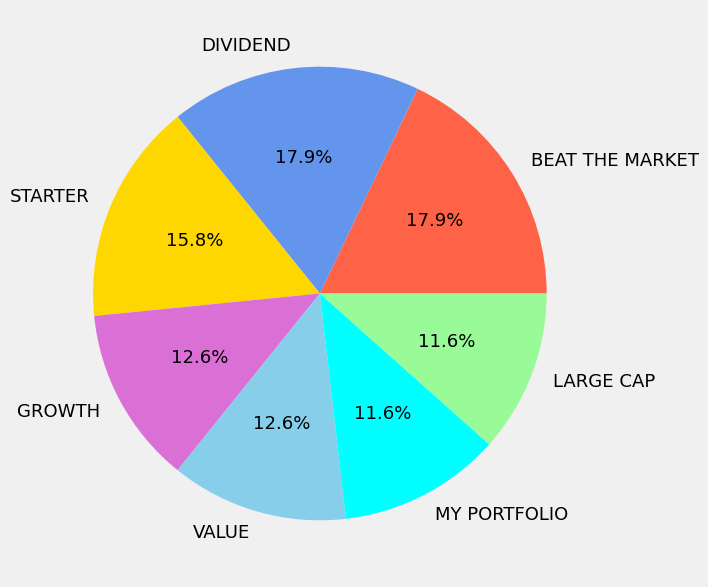

In [25]:
# Plot distribution of optimized portfolios as a pie chart
plt.figure(figsize = (7,7))
plt.title = 'Distribution of Optimum Portfolios'
plt.pie(
    x = train_summary['Portfolio'].value_counts().values,
    labels = train_summary['Portfolio'].value_counts().index.to_list(),
    autopct = '%1.1f%%',
    textprops = {'fontsize':13},
    colors = ['tomato', 'cornflowerblue', 'gold', 'orchid', 'skyblue', 'cyan', 'palegreen']
)
plt.show()


## Efficient Frontier 
Here is a sample for Efficient Frontier plot. This demonstrates what we are doing using Monte Carlo simulation.


In [26]:
def plot_efficient_frontier(all_stock_return_df, portfolio_name, start_date, end_date):
    """
    Draw Efficient Frontier plot for a given portfolio
    Input:
    - portfolio - Name of the portfolio for which Efficient Frontier to be drawn
    Output:
    - Efficient Frontier plot for the given portfolio
    """
    # Get list of ticker symbols for the portfolio
    ticker_list = ALL_PORTFOLIOS[portfolio_name]
    # Get stock price data set
    train_returns_df = all_stock_return_df[start_date:end_date][ticker_list]
    
    # Perform Monte Carlo simulation for the portfolio
    simulation_results, _, _ = simulate(train_returns_df, portfolio_name) 

    # Plot Efficient Frontier graph
    plt.style.use('fivethirtyeight') # ('classic') 
    f, ax = plt.subplots()
    ax.set_title('Efficient Frontier Plot\nOptimum Portfolio: ' + portfolio_name)
    plt.xlabel('Volatility')
    plt.ylabel('Annualized Return %')
    x = simulation_results['Volatility']
    y = simulation_results['Return']
    z = simulation_results['Sharpe Ratio']
    points = plt.scatter(x, y, c=z, s=50, cmap='PuOr') #,cmap='Spectral_r') 
    f.colorbar(points, label="Sharpe Ratio")
    plt.show()
 
    return None


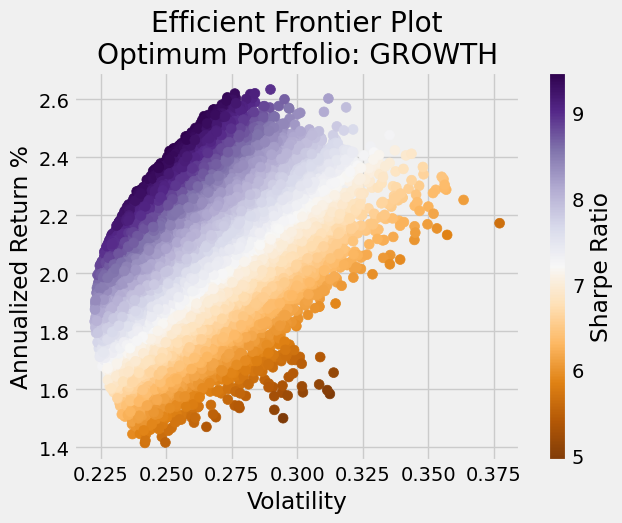

In [52]:
# Find last optimum portfolio name from train_summary
portfolio = train_summary['Portfolio'][train_summary.shape[0] - 1]

plot_efficient_frontier(all_stock_returns_df, portfolio, '2023-01-01', '2023-01-31')


## Hybrid Sharpe Ratio, Volatility, and Returns
These visualizations are specially meaningful for Hybrid Optimization.

In [54]:
# Setup the model file name
model_file = get_file_name('Models/Portfolio_Optimization_Model_')

# Fetch model_df data
model_df = pd.read_csv(model_file,
                       parse_dates=['Start Date', 'End Date'])

# Slice part of the time series
plot_start, plot_end = '2021-01-01', '2022-07-01'


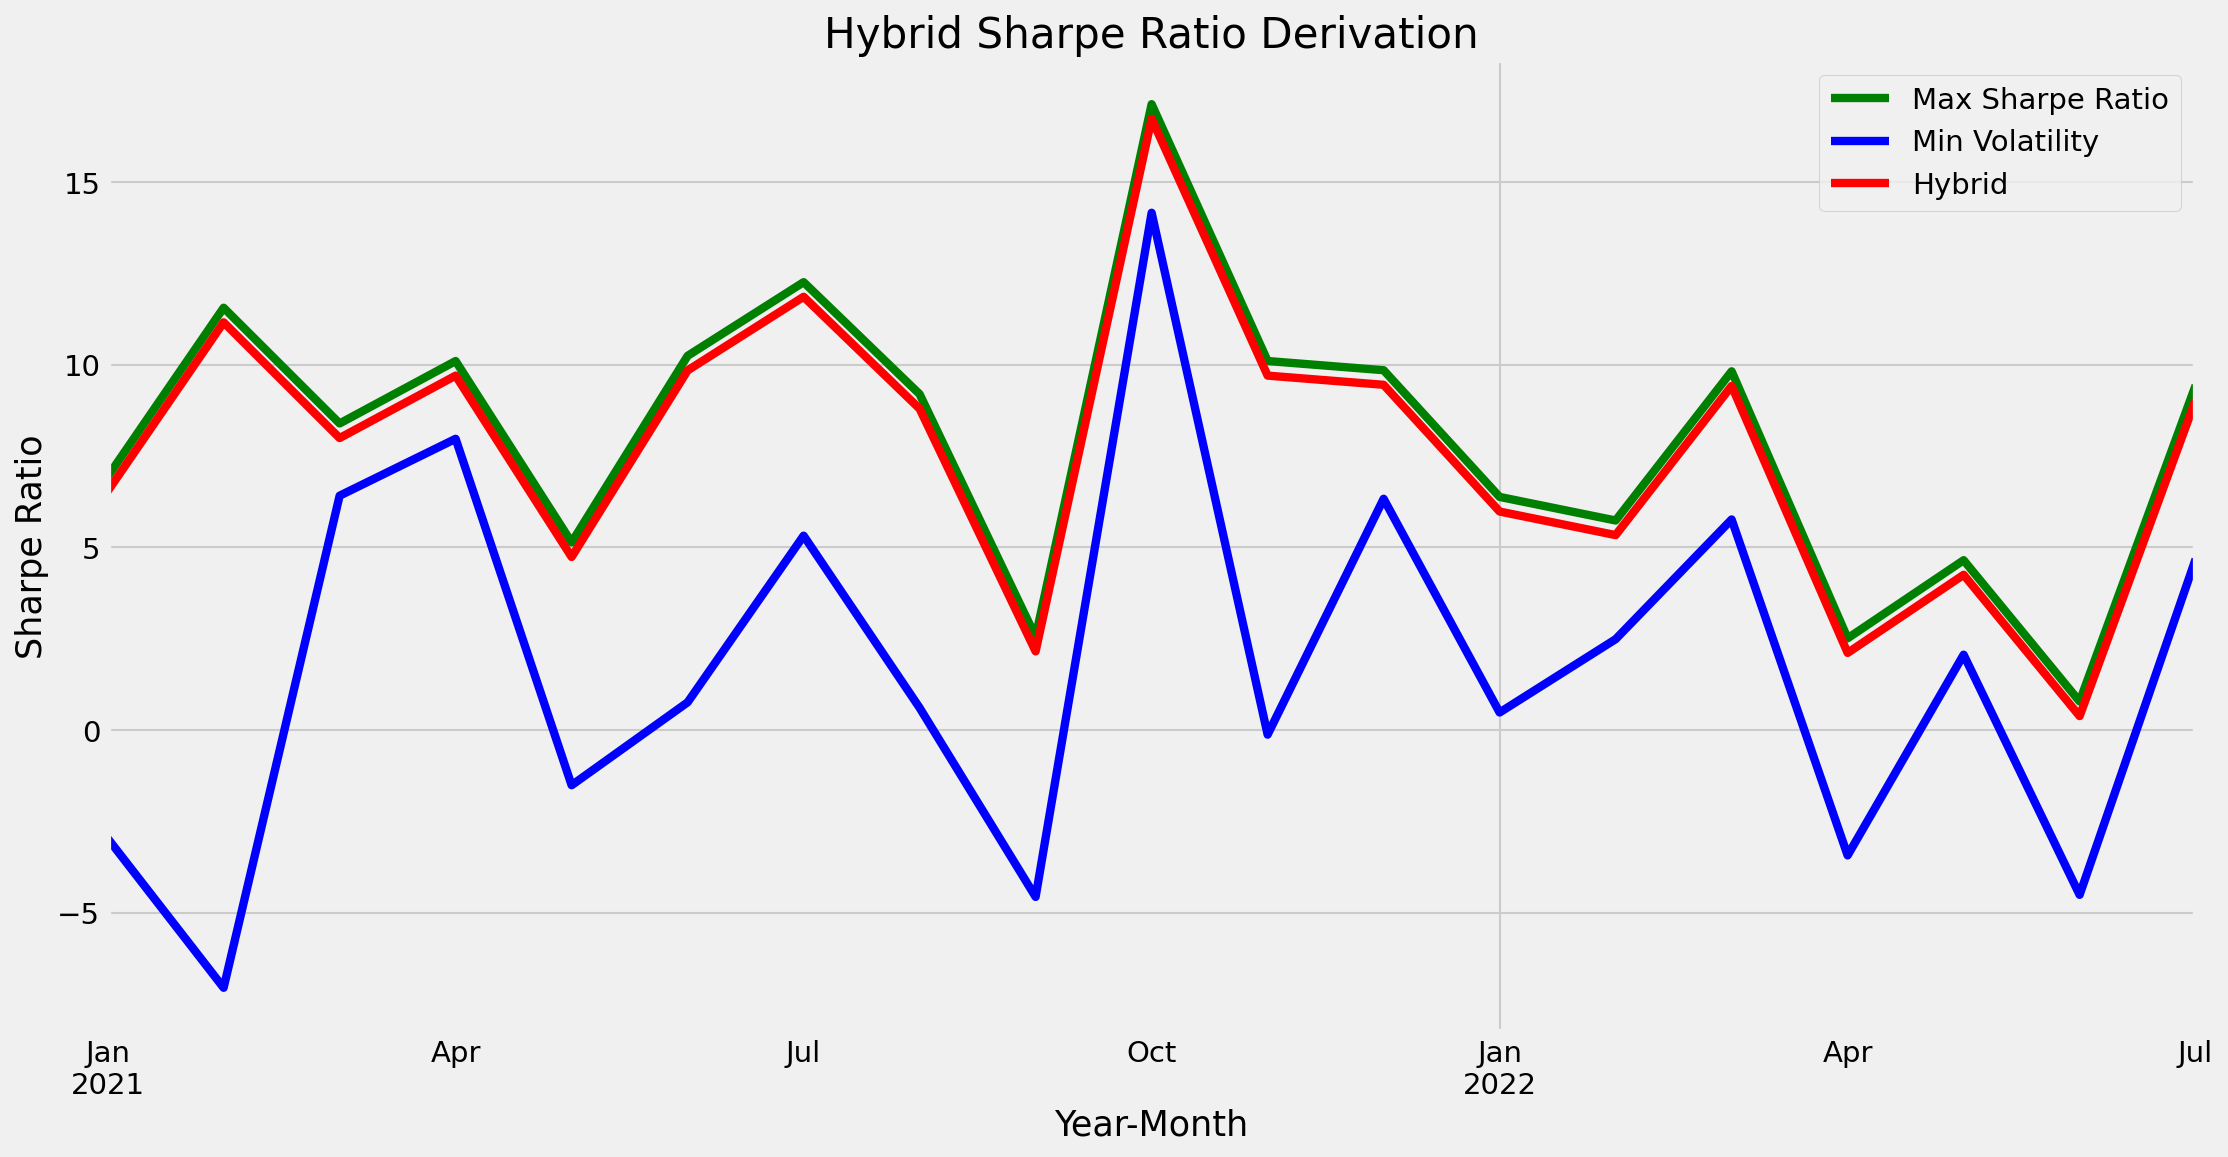

In [55]:
# Plot visualization for Hybrid Sharpe Ratio Derivation from Max Sharpe Ratio and Min Volatility records
# Create a dataframe
plot_df = pd.DataFrame({'Start Date': model_df['Start Date'],
                        'Max Sharpe Ratio': model_df['S Sharpe Ratio'] + 0.4,
                        'Min Volatility': model_df['V Sharpe Ratio'] - 0.4,
                        'Hybrid': model_df['Sharpe Ratio']
                       })

# Set 'Start Date' as index of the dataframe
plot_df.set_index('Start Date', drop=True, inplace=True)
plot_df = plot_df[plot_start:plot_end]

# Create plot
title = 'Hybrid Sharpe Ratio Derivation'
plot_data(plot_df, title, 'Year-Month', 'Sharpe Ratio', colors=['g', 'b', 'r'])


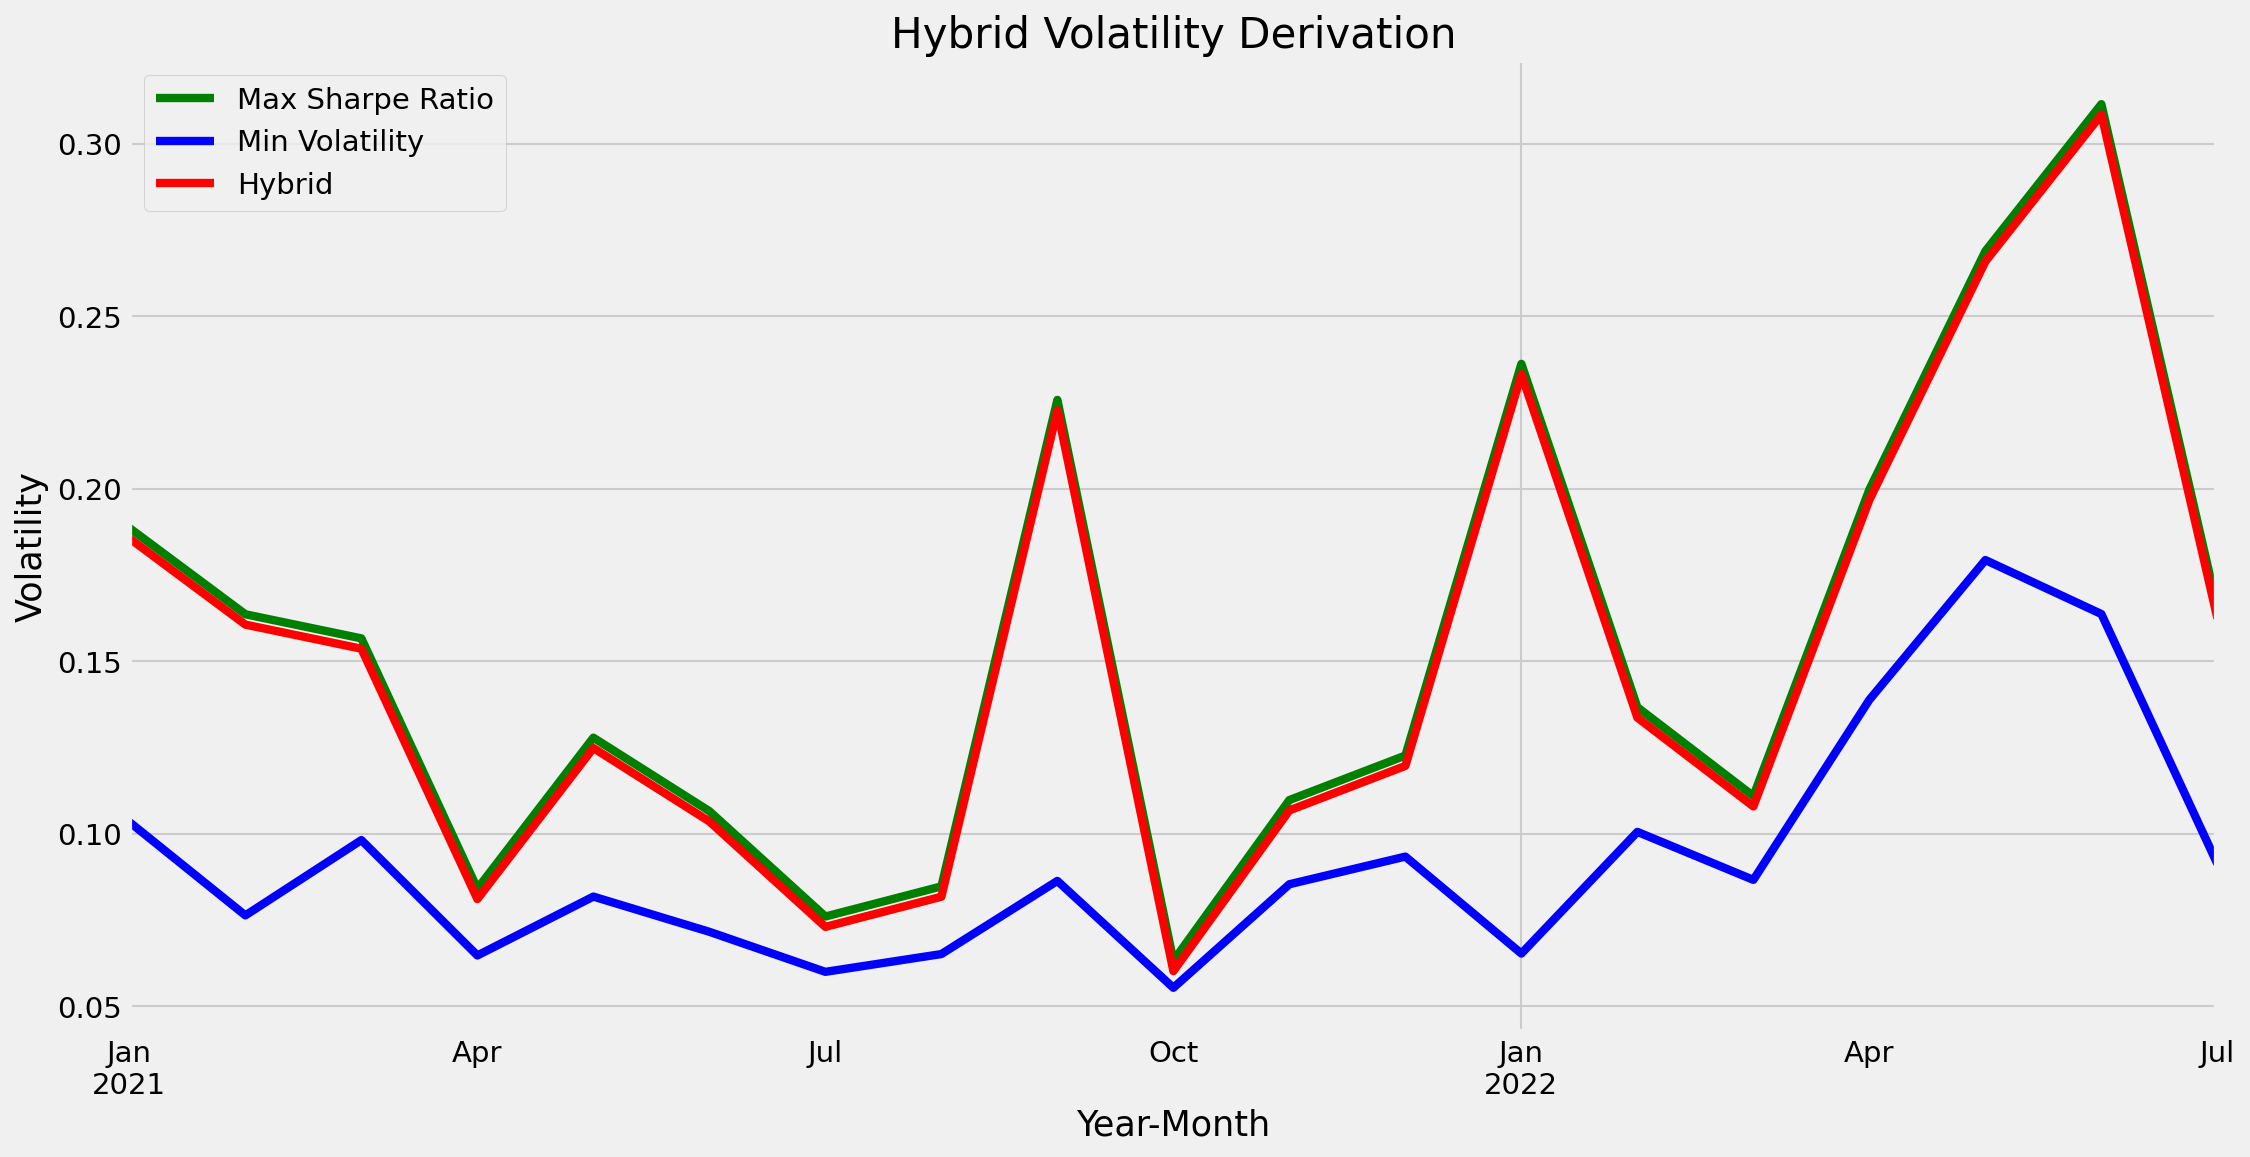

In [56]:
# Plot visualization for Hybrid Volatility Derivation from Max Sharpe Ratio and Min Volatility records
# Create dataframe from Volatility values
plot_df = pd.DataFrame({'Start Date': model_df['Start Date'],
                        'Max Sharpe Ratio': model_df['S Volatility'] + 0.003,
                        'Min Volatility': model_df['V Volatility'] - 0.003,
                        'Hybrid': model_df['Volatility']
                       })

# Set 'Start Date' as index of the dataframe
plot_df.set_index('Start Date', drop=True, inplace=True)
plot_df = plot_df[plot_start:plot_end]

# Create plot
title = 'Hybrid Volatility Derivation'
plot_data(plot_df, title, 'Year-Month', 'Volatility', colors=['g', 'b', 'r'])


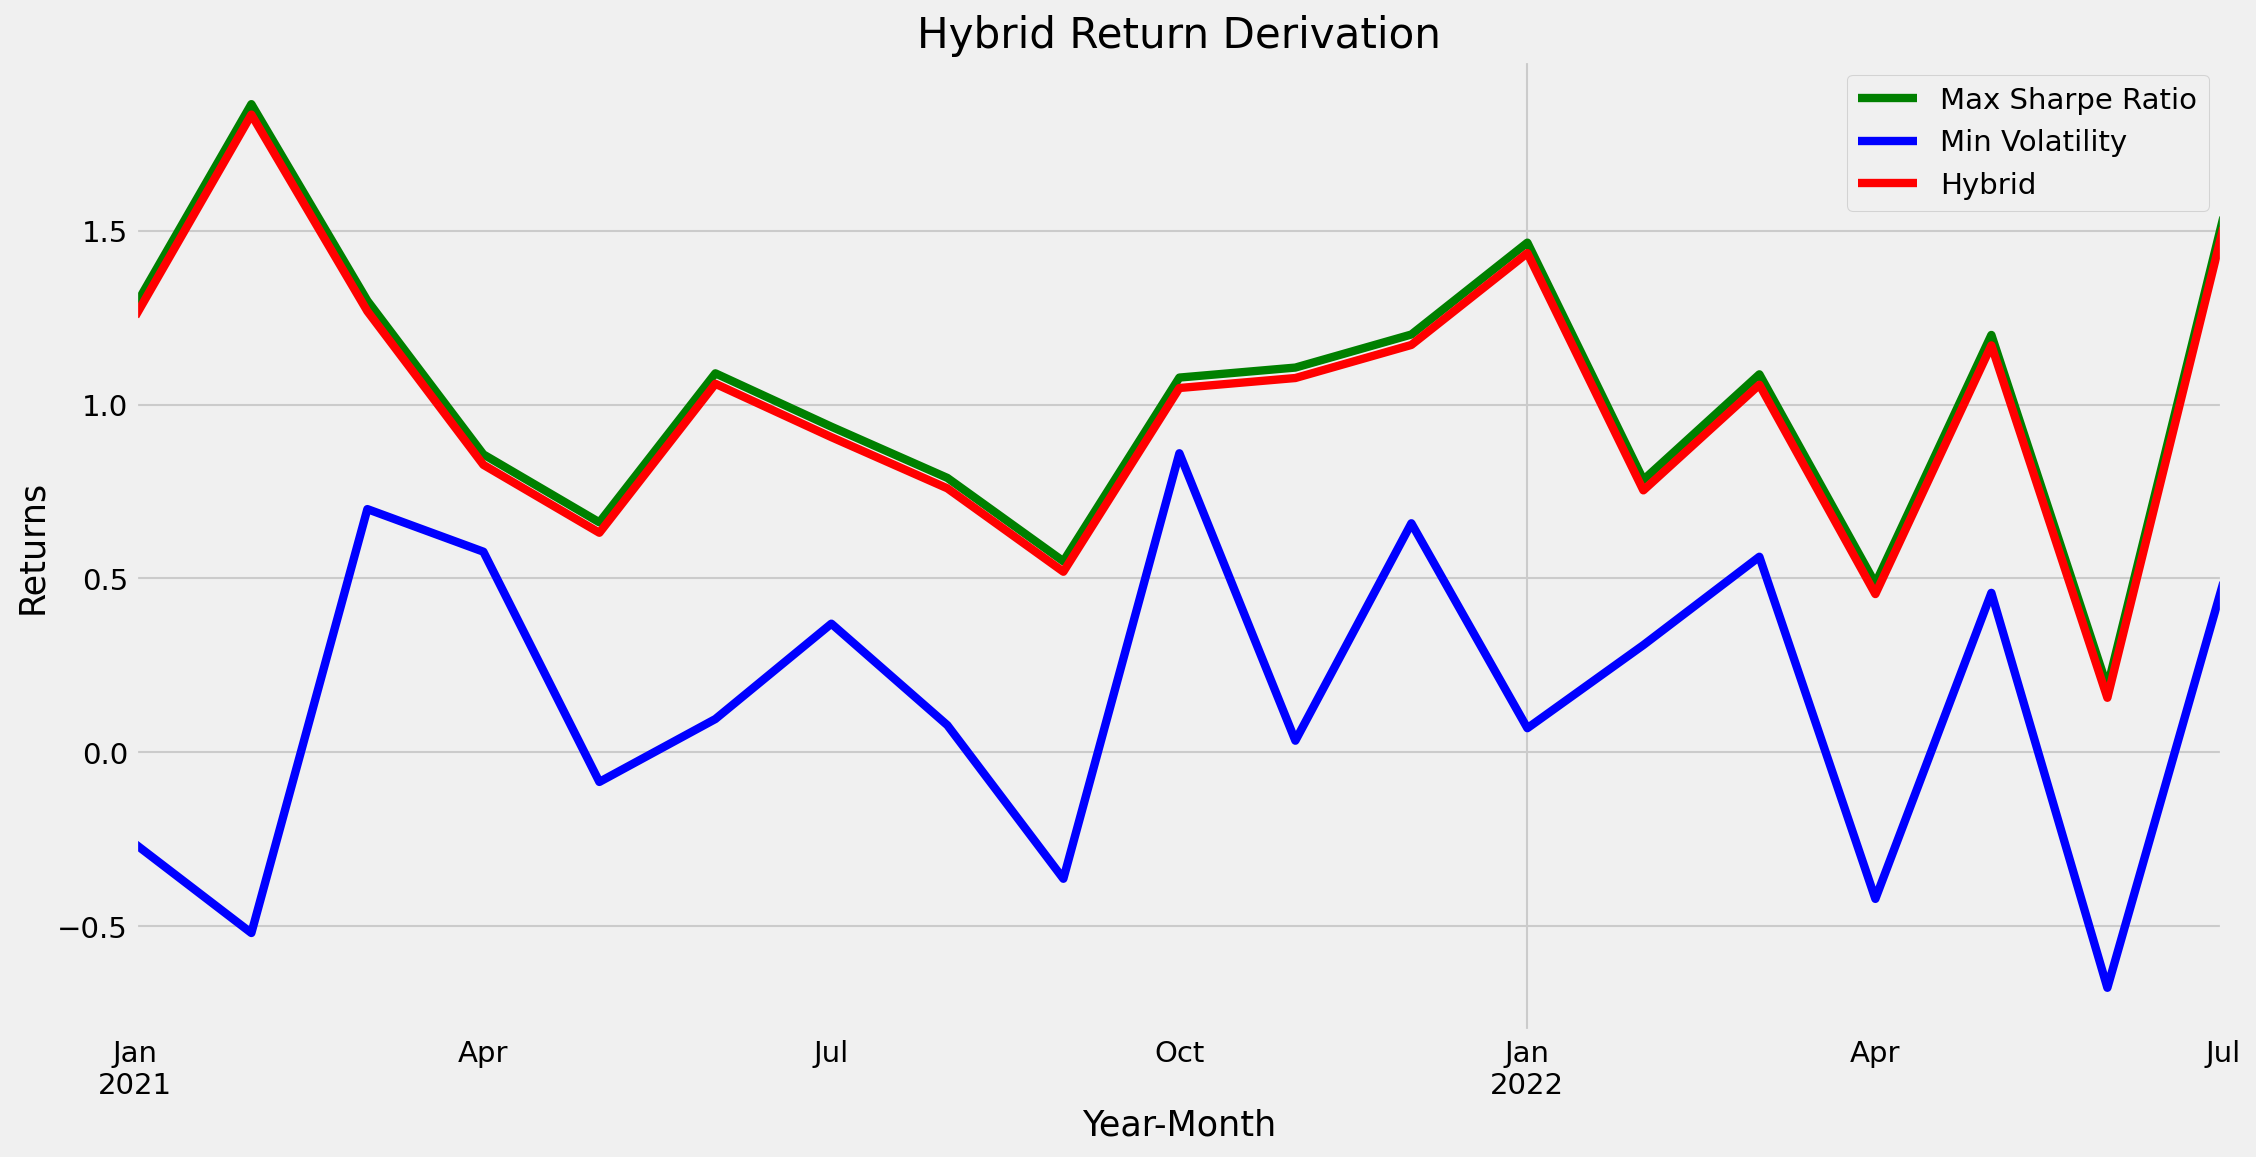

In [57]:
# Plot visualization for Hybrid Return with Max Sharpe Ratio Return and Min Volatility Returns 
# Create dataframe from Volatility values
plot_df = pd.DataFrame({'Start Date': model_df['Start Date'],
                        'Max Sharpe Ratio': model_df['S Return'] + 0.03,
                        'Min Volatility': model_df['V Return'] - 0.03,
                        'Hybrid': model_df['Return']
                       })

# Set 'Start Date' as index of the dataframe
plot_df.set_index('Start Date', drop=True, inplace=True)
plot_df = plot_df[plot_start:plot_end]

# Create plot
title = 'Hybrid Return Derivation'
plot_data(plot_df, title, 'Year-Month', 'Returns', colors=['g', 'b', 'r'])


## Back Testing
Validation is done through back testing. Prior months optimum portfolio and it's weights are used for predicting performances for the current month. Since Stock Market moves up and down fashion known as "random walk", we validate effectiveness of Monte Carlo Simulation based Portfolio Optimization by checking that a longer term moving average of optimied portfolio return generally stays above a benchmark. We will use 3 or 5 years moving average of optimum portfolio and "S&P-500 10 Year Average Return" as a benchmark for this validation.


In [58]:
def validate(all_stock_returns_df, portfolio, start_date, end_date, weights):
    """
    Each of the trained ensamble models are meant for predicting subsequest year's optimum 
    portfolio. This routine predicts poertfolio performance.
    Input:
    - pfo_daily_returns_df - Daily Returns dataframe for a portfolio
    - portfolio - Name of the associated portfolio
    - start_date - Start date of the training data
    - end_date - end date of the training data
    - weights - Weights of portfolio ticker symbols
    Output:
    - pfo_returns - Predicted return for the portfolio 
    - pfo_volatility - Predicted portfolio volatility or standard deviation
    - pfo_sharpe_ratio - Predicted portfolio Sharpe Ratio
    """
    # Extract the dataset relevant for current prediction 
    pfo_daily_returns_df = all_stock_returns_df[start_date:end_date][ALL_PORTFOLIOS[portfolio]]
    
    # Calculate geometric mean of daily returns
    mean_returns = g_mean(pfo_daily_returns_df)

    # Get covariance matrix for the daily returns data
    cov_matrix = pfo_daily_returns_df.cov() 
    
    # Calculate portfolio performance
    pfo_returns, pfo_volatility, pfo_sharpe_ratio = \
        get_portfolio_performance(weights, mean_returns, cov_matrix)

    # Return predicted portfolio return, volatility and Sharpe Ratio 
    return pfo_returns, pfo_volatility, pfo_sharpe_ratio 


In [59]:
def validate_all(train_summary, freq=TRAIN_FREQ):
    """
    For each of the prediction period (shown below) use appropriate base estimator model to 
    predict annual return and contrast against the actual portfolio return (validate).
    Input:
    - train_summary - training summary data
    - window - training window (number of years of stock return data)
    Ourput:
    - Validation Summary results
    """
    start_dates, end_dates, portfolios, sharpe_ratios, volatilities, proj_returns, \
        proj_s_return, proj_v_return, actual_returns, weights \
        = [], [], [], [], [], [], [], [], [], []

    # Get period and window for the freq
    period, window = get_period_window(freq)
       
    # Loop through train_summary dataframe records
    for i in range(train_summary.shape[0]):
        
        # Determine start and end dates for each period
        current = train_summary.iloc[i]
        start_date = current['End Date'] + dt.timedelta(days=1)
        if start_date <= (dt.datetime.today().date() - relativedelta.relativedelta(months=window)):
            if period == 'months':
                end_date = start_date + relativedelta.relativedelta(months=window) - dt.timedelta(days=1)
            else: 
                end_date = start_date + relativedelta.relativedelta(days=window) 
        
            # Use validation routine to determine portfolio return, volatility, and Sharpe Ratio
            pfo_return, pfo_volatility, pfo_sharpe_ratio = validate(all_stock_returns_df,
                                                                    current['Portfolio'],
                                                                    start_date,
                                                                    end_date,
                                                                    current['Weights'])
            # Append new values
            start_dates.append(start_date)
            end_dates.append(end_date)
            portfolios.append(current['Portfolio'])
            sharpe_ratios.append(pfo_sharpe_ratio)
            volatilities.append(pfo_volatility)
            proj_returns.append(current['Return'])
            actual_returns.append(pfo_return)
            weights.append(current['Weights'])
        
    # Construct validation summary dataframe
    val_summary = pd.DataFrame({'Start Date': start_dates,
                                'End Date': end_dates,
                                'Portfolio': portfolios,
                                'Sharpe Ratio': sharpe_ratios,
                                'Volatility': volatilities,
                                'Predicted Return': proj_returns,
                                'Actual Return': actual_returns,
                                'Weights': weights
                               })
    
    # Set 'Start Date' as index of the dataframe
    val_summary.set_index('Start Date', drop=True, inplace=True)

    # Setup the validation file name
    valid_result_file = get_file_name('Models/Portfolio_Optimization_Validation_')
    
    # Write to validation results file
    val_summary.to_csv(valid_result_file)
        
    return val_summary
    

In [60]:
# Perform validation by back testing
val_summary = validate_all(train_summary, TRAIN_FREQ)

# Print validation results 
print(f"{val_summary[['Portfolio', 'Predicted Return', 'Actual Return']]}")


                  Portfolio  Predicted Return  Actual Return
Start Date                                                  
2015-05-01  BEAT THE MARKET          1.151001       0.847311
2015-06-01           GROWTH          1.303153       0.457057
2015-07-01  BEAT THE MARKET          0.586264       0.349723
2015-08-01     MY PORTFOLIO          1.302006      -0.781341
2015-09-01            VALUE          0.452383       0.018472
2015-10-01        LARGE CAP          0.304172       0.951888
2015-11-01        LARGE CAP          1.212808       0.169398
2015-12-01  BEAT THE MARKET          1.116770       0.020387
2016-01-01  BEAT THE MARKET          1.491223      -1.372654
2016-02-01        LARGE CAP          0.687048      -0.187895
2016-03-01         DIVIDEND          0.510391       0.679324
2016-04-01            VALUE          1.388086       0.008130
2016-05-01     MY PORTFOLIO          0.904408       0.632854
2016-06-01     MY PORTFOLIO          0.870252      -0.092128
2016-07-01          STAR

In [61]:
val_summary.describe()

,Sharpe Ratio,Volatility,Predicted Return,Actual Return
count,94.000000,94.000000,94.000000,94.000000
mean,1.392163,0.196575,0.955888,0.244932
std,3.482898,0.135661,0.508550,0.788332
min,-6.177623,0.053008,-0.923784,-1.720376
25%,-1.186546,0.112213,0.640160,-0.091535
50%,1.415563,0.164482,0.901246,0.274480
75%,4.152238,0.245373,1.210767,0.624576
max,8.769278,0.961620,2.400587,2.760362


In [62]:
def plot_predicted_vs_actual_returns(returns_df, title_text, colors=['g', 'b']):
    """
    Plot model validation results with the following line graphs:
    - S&P-500 10 Year Average Return
    - 5 Years Moving Average of Actual Returns 
    - 3 Years Moving Average of Actual Returns (Optional)
    - Actual Return (Optional)
    Input:
    - actual_return - actual return data frame
    - title_text - title text
    - freq - frequency
    - years - number of years for moving average
    - include_actual - if true, Actual Returns line graph is printed
    """       
    # Set plot size
    plt.figure(figsize=(16, 8), dpi=150)
        
    plot_data(returns_df, title_text, 'Year-Month', 'Annualized Return', colors)
    
    plt.show();
    
    # Return none
    return None

<Figure size 2400x1200 with 0 Axes>

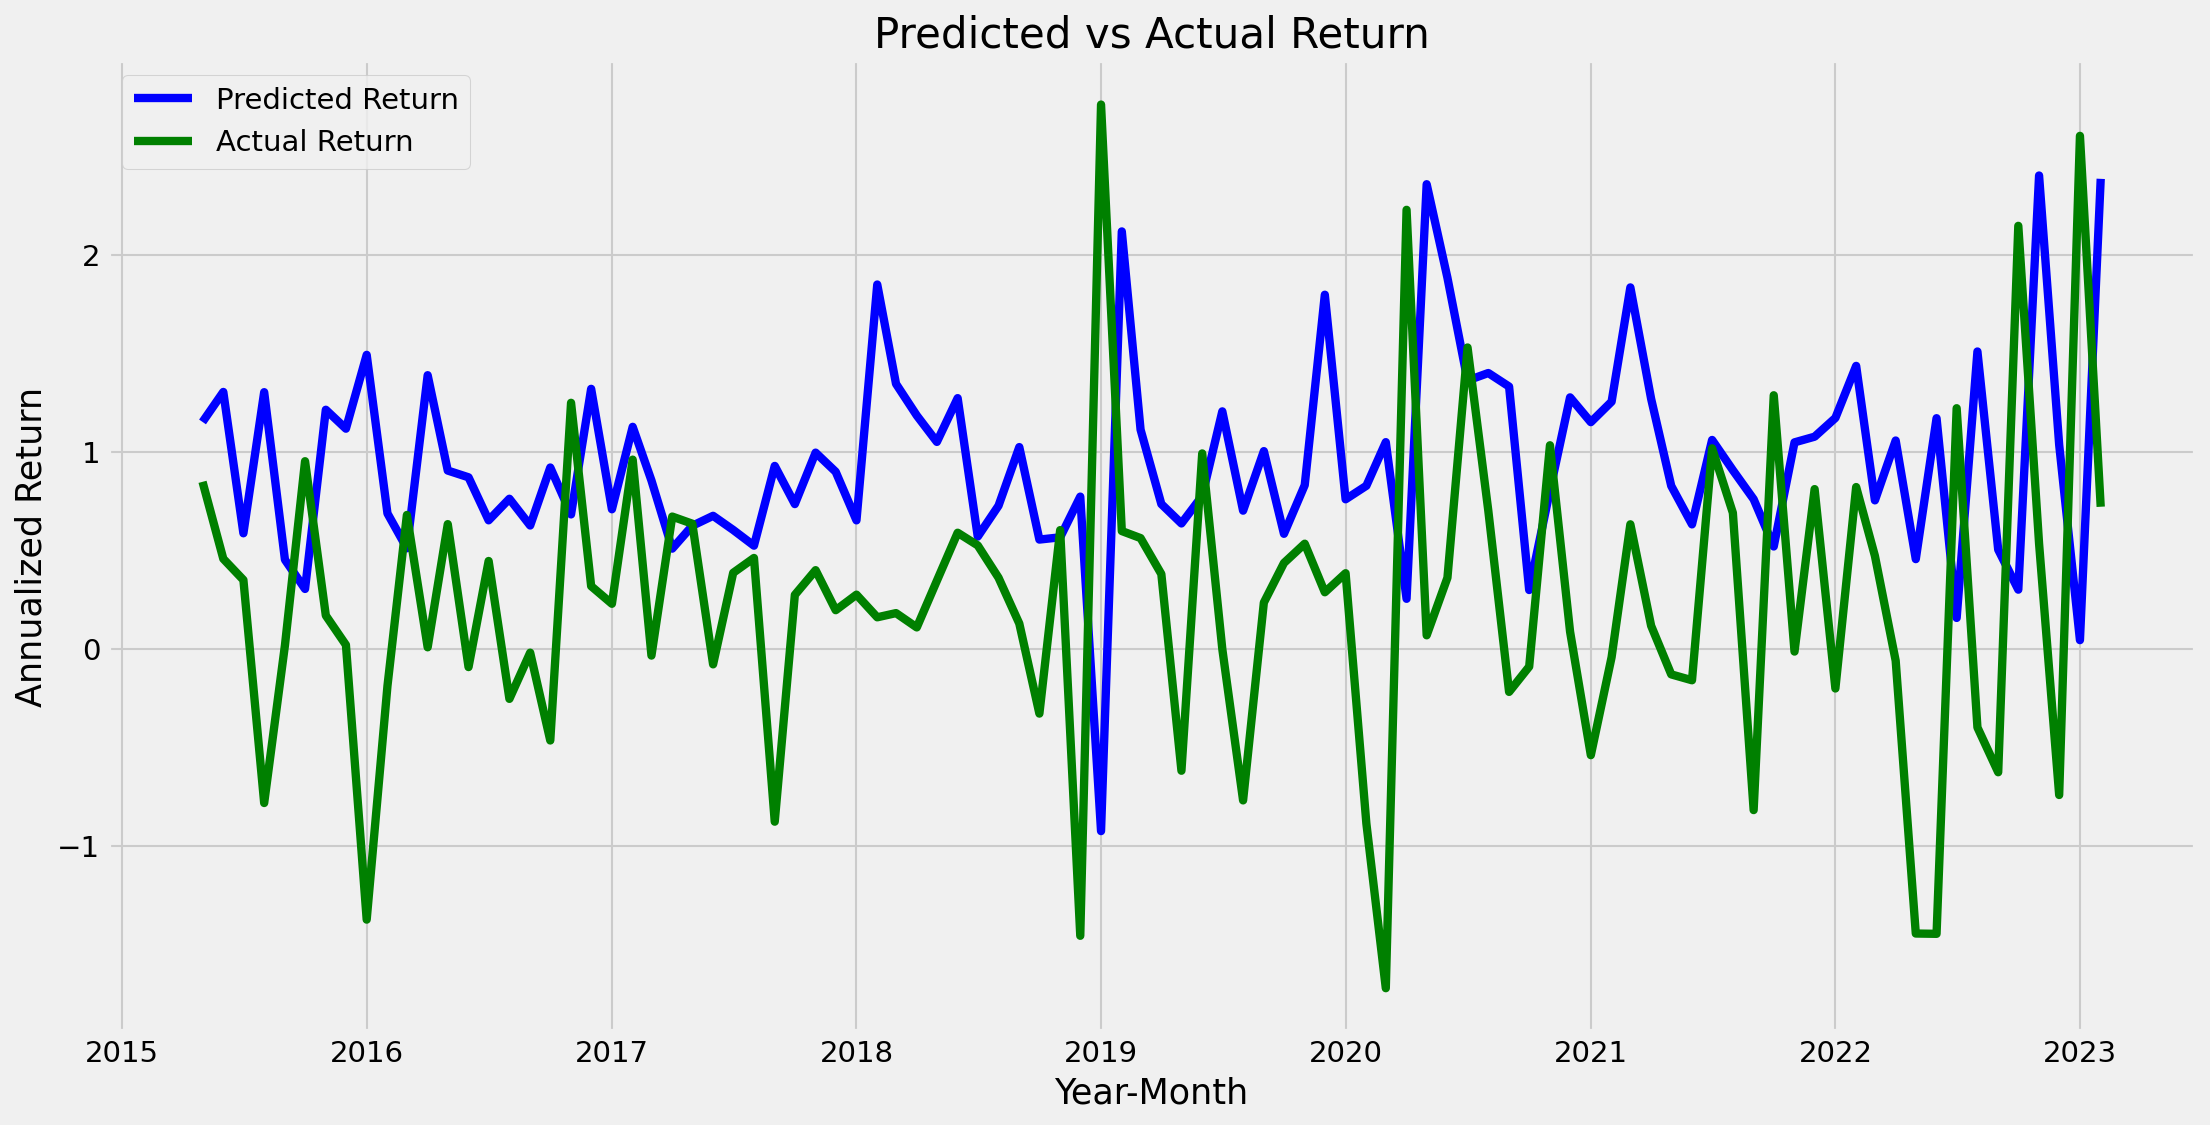

In [63]:
title = 'Predicted vs Actual Return'
columns = ['Predicted Return', 'Actual Return']
plot_predicted_vs_actual_returns(val_summary[columns], title_text=title, colors=['b', 'g'])


## Optimized Portfolio Returnd compared to S&P 500 Benchmark
From the results below, it is clear that with long term perspective, Optimized Portfolio returns are far better than the S&P 500 Benchmark return. Let's visualize this a bit with a closer look.


### Actual return plot with moving average and S&P-500 10 Year Average

In [64]:
def plot_model_returns(returns_df, title_text):
    """
    Plot model validation results with the following line graphs:
    - S&P-500 10 Year Average Return
    - 5 Years Moving Average of Actual Returns 
    - 3 Years Moving Average of Actual Returns (Optional)
    - Actual Return (Optional)
    Input:
    - actual_return - actual return data frame
    - title_text - title text
    - freq - frequency
    - years - number of years for moving average
    - include_actual - if true, Actual Returns line graph is printed
    """       
    # Set plot size
    plt.figure(figsize=(16, 8), dpi=150)
        
    plot_data(returns_df, title_text, 'Year-Month', 'Annualized Return')
    
    plt.show();
    
    # Return none
    return None
    

In [65]:
val_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 2015-05-01 to 2023-02-01
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   End Date          94 non-null     object 
 1   Portfolio         94 non-null     object 
 2   Sharpe Ratio      94 non-null     float64
 3   Volatility        94 non-null     float64
 4   Predicted Return  94 non-null     float64
 5   Actual Return     94 non-null     float64
 6   Weights           94 non-null     object 
dtypes: float64(4), object(3)
memory usage: 5.9+ KB


In [66]:
#val_summary.set_index(pd.to_datetime(val_summary.index), drop=True, inplace=True)

<Figure size 2400x1200 with 0 Axes>

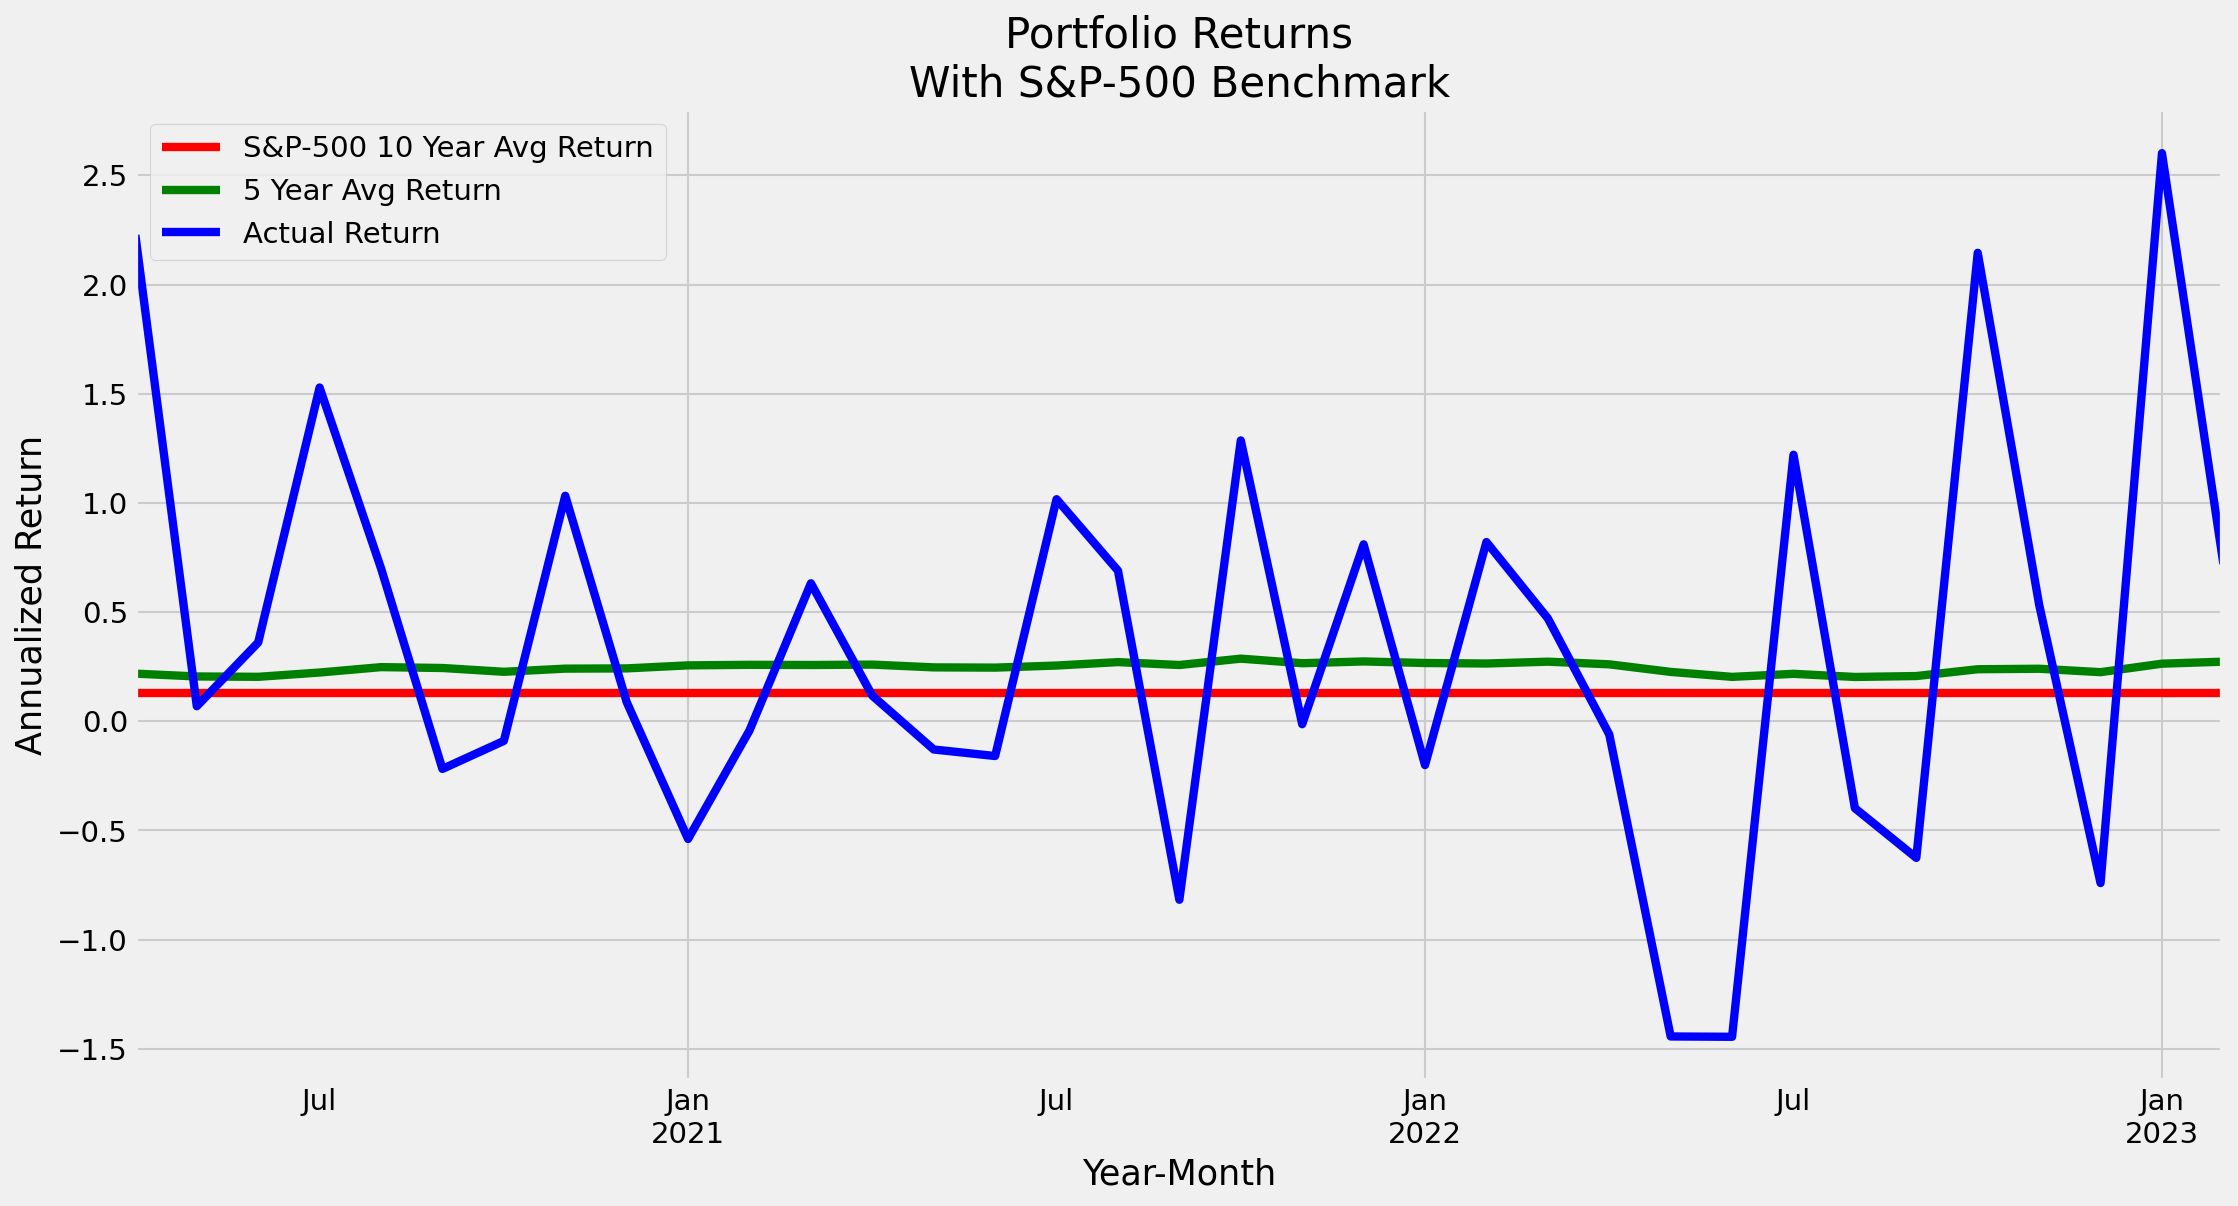

<Figure size 2400x1200 with 0 Axes>

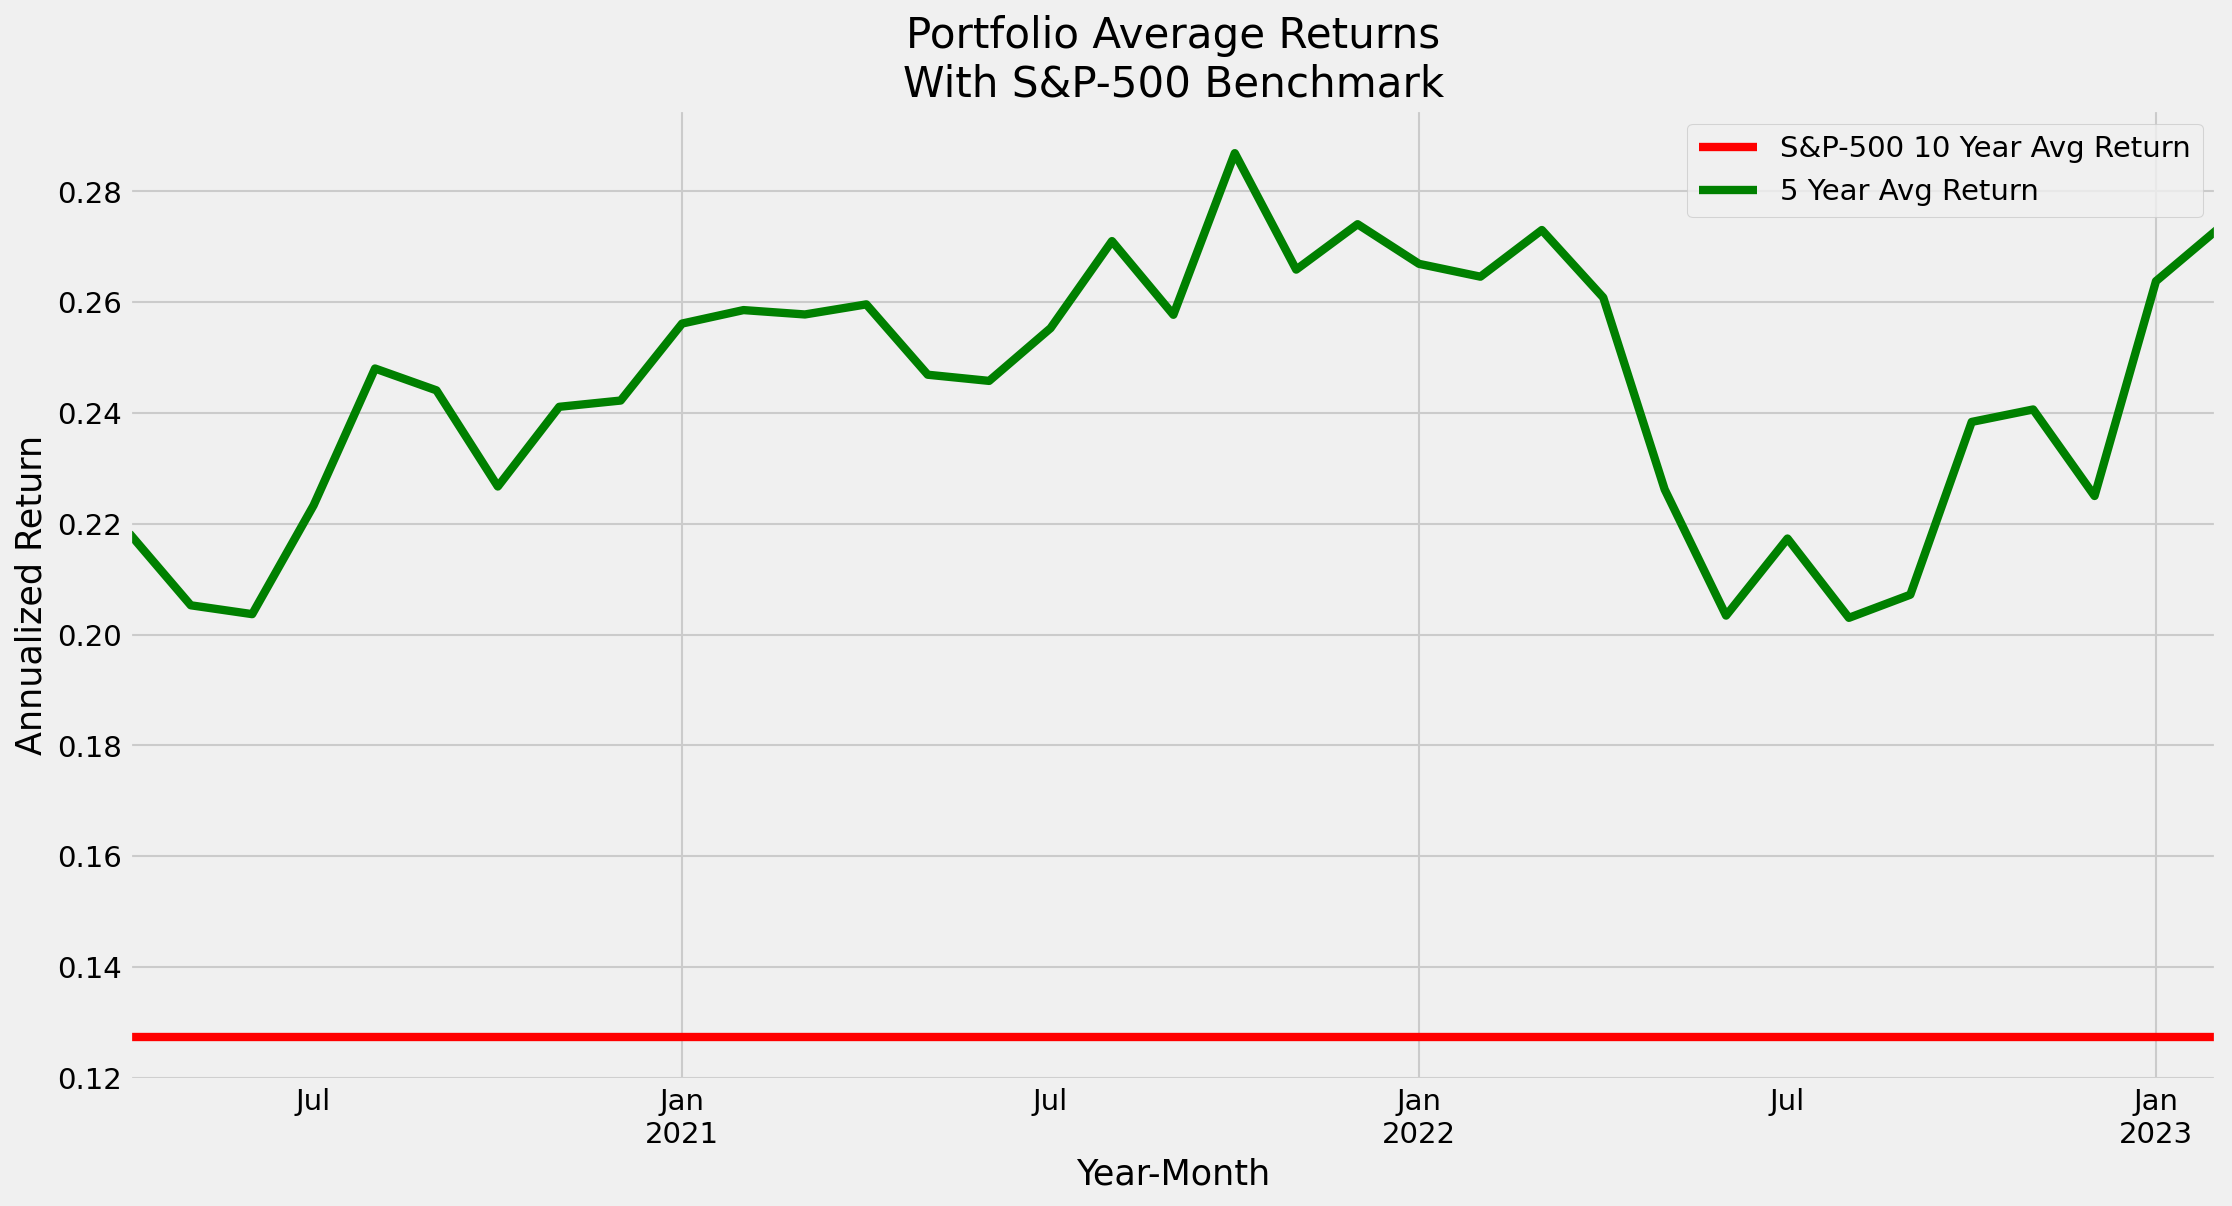

In [67]:
# Determine multiplier
if TRAIN_FREQ == 'M':
    multiplier = 12
elif TRAIN_FREQ == 'Q':
    multiplier = 4
elif TRAIN_FREQ == 'A':
    multiplier = 1

# Construct series objects
val_summary.set_index(pd.to_datetime(val_summary.index), drop=True, inplace=True)
actual_return = val_summary['Actual Return']
actual_return_5y = get_moving_average(actual_return, 5 * multiplier)['2020-04-01':]
sp500_return = pd.Series([SP500_10YEAR_AVG for x in range(len(actual_return.index))],
                         index=actual_return.index)

# Summary returns dataframes 
avg_returns_df = pd.DataFrame({'S&P-500 10 Year Avg Return': sp500_return,
                               '5 Year Avg Return': actual_return_5y
                              }).dropna()
act_returns_df = pd.DataFrame({'S&P-500 10 Year Avg Return': sp500_return,
                               '5 Year Avg Return': actual_return_5y,
                               'Actual Return': actual_return
                              }).dropna()

# Set Datetime index for these data frames
avg_returns_df.set_index(pd.to_datetime(avg_returns_df.index), drop=True, inplace=True)
act_returns_df.set_index(pd.to_datetime(act_returns_df.index), drop=True, inplace=True)

title_text = 'Portfolio Returns\nWith S&P-500 Benchmark'
_ = plot_model_returns(act_returns_df, title_text)

title_text = 'Portfolio Average Returns\nWith S&P-500 Benchmark'
_ = plot_model_returns(avg_returns_df, title_text)


In [68]:
act_returns_df.describe()


,S&P-500 10 Year Avg Return,5 Year Avg Return,Actual Return
count,3.500000e+01,35.000000,35.000000
mean,1.274000e-01,0.244352,0.347264
std,2.816079e-17,0.023664,0.938383
min,1.274000e-01,0.203028,-1.444699
25%,1.274000e-01,0.225616,-0.179805
50%,1.274000e-01,0.246914,0.117387
75%,1.274000e-01,0.262321,0.815601
max,1.274000e-01,0.286911,2.601613


In [69]:
act_returns_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35 entries, 2020-04-01 to 2023-02-01
Freq: MS
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   S&P-500 10 Year Avg Return  35 non-null     float64
 1   5 Year Avg Return           35 non-null     float64
 2   Actual Return               35 non-null     float64
dtypes: float64(3)
memory usage: 1.1 KB


In [70]:
# Dataframe to be used for prediction

ma_returns_df = act_returns_df

# Set 'Start Date' as index of the dataframe
ma_returns_df.index = pd.to_datetime(ma_returns_df.index, format='%Y-%m-%d')

# Setup the Moving Average file name
ma_returns_file = get_file_name('Models/Moving_Average_Returns_')

# Write to Moving Average file
ma_returns_df.to_csv(ma_returns_file)


In [71]:
# Check if all '5 Year Avg Return' is greater than benchmark
count1 = (ma_returns_df['5 Year Avg Return'] < ma_returns_df['S&P-500 10 Year Avg Return']).sum()
max1, min1 = ma_returns_df['5 Year Avg Return'].max(), ma_returns_df['5 Year Avg Return'].min()

print(f"Spread of '5 Year Moving Avg Return': [{min1} - {max1}]\n")

if count1 == 0:
    print("All '5 Year avg Return' values are greater than 'S&P-500 10 Year Avg Return'")
else: 
    print(f"{count1} occurrences of '5 Year avg Return' values are less than 'S&P-500 10 Year Avg Return'")
    

Spread of '5 Year Moving Avg Return': [0.20302769111536417 - 0.2869106114292713]

All '5 Year avg Return' values are greater than 'S&P-500 10 Year Avg Return'


## Predict
We have trained an ensemble model for predicting optimum portfolio and it's weights for a given month. It uses prior month's optimum portfolio.

In [72]:
def predict(ma_returns_df, pred_start_date, period_type):
    """
    From trained ensemble models determine Optimum Portfolio, and Stock Allocation data.
    Input:
    - ma_returns_df - moving average returns data frame 
    - pred_start_date - start date for prediction window
    - period_type - prediction period type, M - Month, Q - Quarter, A - Annual 
    Output:
    - allocation - stock tickers and their weights
    """
    # Open data model file
    model_file = get_file_name('Models/Portfolio_Optimization_Model_')
    model_df = pd.read_csv(model_file, 
                           usecols=['Start Date', 'Portfolio', 'Return', 'Weights'],
                           parse_dates=['Start Date'])

    # Determine period_text and window for period_type
    period_text, window = get_period_attr(period_type)
        
    # Determine display text for optimization rule
    optm_rule_name = get_optm_rule_name(OPTIMIZATION_RULE)
            
    # Set 'Start Date' as index of the dataframe
    model_df.set_index('Start Date', drop=True, inplace=True)

    # Get the prior period model record
    ref_date = pd.to_datetime(pred_start_date) - relativedelta.relativedelta(months = window)
    
    model_rec = model_df.loc[ref_date]
    
    optimum_pfo = model_rec['Portfolio']
    pfo_tickers = ALL_PORTFOLIOS[optimum_pfo]
    pfo_weights = model_rec['Weights']
    pfo_weights = pfo_weights[1:-1].split() 
    
    # Print optimum portfolio and it's asset allocation
    print('\nStock Portfolio Optimization\n============================')
    print(f'Run Date/time ......................... {dt.datetime.now()}')
    print('Prediction Window ..................... ' + period_text)
    print('Optimization Rule ..................... ' + optm_rule_name)
    print('Start Date ............................ ' + pred_start_date)

    ## Calculate moving average return
    ma_rec = ma_returns_df.loc[ref_date]
    ma_return_5y = ma_rec['5 Year Avg Return']
    current_return = ma_rec['Actual Return']
    snp_return_10y = ma_rec['S&P-500 10 Year Avg Return']
    
    print('Optimal Portfolio ..................... ' + optimum_pfo)
    print("5 Year Average Return ................. {:.4f}".format(round(ma_return_5y, 4)))
    print("S&P-500 Benchmark Return .............. {:.4f}".format(round(snp_return_10y, 4)))
    
    allocation = pd.DataFrame({'Stock': pfo_tickers, 'Weight': pfo_weights})
    allocation['Weight'] = allocation['Weight'].astype(float)
    allocation.sort_values(by='Weight', ascending=False, inplace=True)
    allocation.reset_index(drop=True, inplace=True)
    
    print('\nOptimum Asset Allocation:')
    print(allocation)
    
    return None


### Prediction for Current Period
Predict current period's expected return and optimum asset allocation based on trained ensamble models.

In [73]:
# Predict current period's expected returns and optimum asset allocation
allocation_df = predict(ma_returns_df, '2023-03-01', TRAIN_FREQ)



Stock Portfolio Optimization
Run Date/time ......................... 2023-03-30 15:12:16.928768
Prediction Window ..................... Monthly
Optimization Rule ..................... Maximize Sharpe Ratio
Start Date ............................ 2023-03-01
Optimal Portfolio ..................... GROWTH
5 Year Average Return ................. 0.2731
S&P-500 Benchmark Return .............. 0.1274

Optimum Asset Allocation:
   Stock    Weight
0   META  0.822340
1   AAPL  0.150733
2   AMZN  0.020964
3  GOOGL  0.005880
4   NFLX  0.000083


## End of Notebook: Stock Portfolio Optimization - Monte Carlo Simulation
